In [1]:
import warnings

import matplotlib.patheffects as pe
import plot_gwr
import utils
from appgeopy import *
from matplotlib.colors import Normalize, TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Imports ---
from my_packages import *

#### InSAR average velocity

#### Predicted Cumulative Compaction

In [2]:
# --- 1. File Paths ---
FEATHER_FILE_PATH = r"D:\1000_SCRIPTS\003_Project002\20250917_GTWR002\3L_TestRun_6_GWR_AllKernels\GWR_Prediction_Output\GWR_Layer_1.feather"
utils.setup_font(r"fonts/verdana.ttf")

# --- 2. Data Column Names ---
# (These are now used only for coordinates and time)
DATETIME_STRING_COLUMN = "datetime_str"
DATETIME_OBJECT_COLUMN = "datetime"
X_COORD_COLUMN = "X_TWD97"
Y_COORD_COLUMN = "Y_TWD97"

# --- 3. Coordinate Reference Systems (CRS) ---
SOURCE_CRS = "EPSG:3826"
DISPLAY_CRS = "EPSG:4326"

COLORBAR_LABEL = "Cumulative Compaction"  # Label for the pcolormesh

processed_df = plot_gwr.load_and_preprocess_data(
    filepath=FEATHER_FILE_PATH,
    datetime_str_col=DATETIME_STRING_COLUMN,
    datetime_obj_col=DATETIME_OBJECT_COLUMN,
)

data_cube_obj = geocube.DataCube.from_dataframe(
    df=processed_df,
    time_col=DATETIME_OBJECT_COLUMN,
    x_col=X_COORD_COLUMN,
    y_col=Y_COORD_COLUMN,
)

available_times = geocube.DataCube.get_available_times(data_cube_obj)

Successfully loaded font: Verdana
Loading data from D:\1000_SCRIPTS\003_Project002\20250917_GTWR002\3L_TestRun_6_GWR_AllKernels\GWR_Prediction_Output\GWR_Layer_1.feather...
DataCube successfully created from DataFrame.


In [3]:
prediction_cube = data_cube_obj.data_cube["prediction"]
prediction_cube = prediction_cube.rename(
    {X_COORD_COLUMN: "x", Y_COORD_COLUMN: "y", "datetime": "time"}
)
cumdisp_predict_cube = prediction_cube.cumsum(dim="time")
cumdisp_predict_cube = cumdisp_predict_cube.rio.write_crs(SOURCE_CRS)
cumdisp_predict_cube = cumdisp_predict_cube.rio.set_spatial_dims(
    x_dim="x", y_dim="y"
)

reprojected_cumdisp = cumdisp_predict_cube.rio.reproject(DISPLAY_CRS)
reprojected_cumdisp_last = reprojected_cumdisp.sel(time=available_times[-1])
reprojected_cumdisp_last = reprojected_cumdisp_last.to_dataset()
reprojected_cumdisp_last = reprojected_cumdisp_last.rename(
    {"prediction": "pcolormesh_data"}
)

Generating map visualization...
Clipping data to study area boundary...
Adding scale bar and north arrow...
Map generation complete.
Creating inset colorbar...
Applying halo effect to colorbar text...


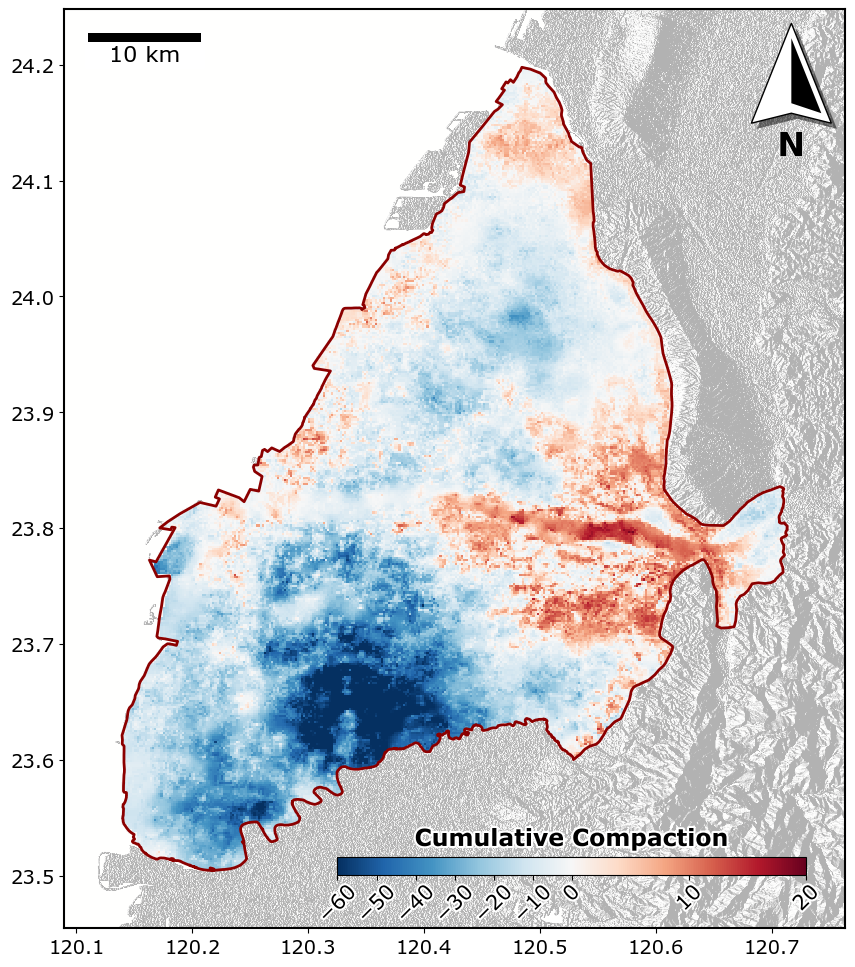

In [5]:
# --- Diverging Map Settings (if USE_DIVERGING_NORM = True) ---
USE_DIVERGING_NORM = True
PLOT_CMAP_DIV = "RdBu_r"
PLOT_VMIN_DIV = -60
PLOT_VMAX_DIV = 20
PLOT_VCENTER_DIV = 0.0

# --- Colorbar Halo Settings ---
USE_TEXT_HALO = True
HALO_SIZE = 3
HALO_COLOR = "white"

# --- 5. Visualization Parameters (Pcolormesh) ---
PLOT_FIGSIZE = (10, 10)
MAP_SCALE = None

plot_norm = TwoSlopeNorm(
    vmin=PLOT_VMIN_DIV, vcenter=PLOT_VCENTER_DIV, vmax=PLOT_VMAX_DIV
)

fig, ax, plot_mesh, scale_factor = plot_gwr.visualize_map(
    reprojected_ds=reprojected_cumdisp_last,
    # variable_name is no longer needed
    cmap=PLOT_CMAP_DIV,
    norm=plot_norm,
    figsize=PLOT_FIGSIZE,
    # Map functions
    map_layers_func=utils.create_choushui_map_layers,
    map_config_func=utils.configure_map_figure,
    add_scale_bar_func=utils.add_scale_bar,
    add_north_arrow_func=utils.add_north_arrow,
    # Map parameters
    target_crs=int(DISPLAY_CRS.split(":")[-1]),
    scale_crs=int(SOURCE_CRS.split(":")[-1]),
    map_scale=MAP_SCALE,
)

# 5. CREATE THE INSET COLORBAR
# (This section uses your *exact* new settings)
if plot_mesh:  # Only create colorbar if plot was successful
    print("Creating inset colorbar...")
    cax = inset_axes(
        ax,
        width="60%",
        height="2%",  # <-- Your setting
        loc="lower center",
        bbox_to_anchor=(0.15, 0.0575, 1, 1),  # <-- Your setting
        bbox_transform=ax.transAxes,
        borderpad=0,
    )
    cbar = plt.colorbar(
        plot_mesh,  # The mappable object returned from visualize_map
        cax=cax,  # The inset axes to draw in
        orientation="horizontal",  # Make it horizontal
    )

    # --- Style the colorbar (using the scale_factor) ---
    base_tick_size = 15  # <-- Your setting
    base_label_size = 17  # <-- Your setting
    scaled_tick_fontsize = int(base_tick_size * scale_factor)
    scaled_label_fontsize = int(base_label_size * scale_factor)

    # --- Set the label ---
    cbar.set_label(
        COLORBAR_LABEL,
        fontsize=scaled_label_fontsize,
        fontweight="bold",
        labelpad=8,
    )
    cax.xaxis.set_label_position("top")

    # --- NEW CODE TO SET TICK INTERVAL ---
    # 1. Get the min/max values from your config (Cell 2)
    vmin = PLOT_VMIN_DIV if USE_DIVERGING_NORM else PLOT_VMIN_SEQ
    vmax = PLOT_VMAX_DIV if USE_DIVERGING_NORM else PLOT_VMAX_SEQ

    # 2. Create a list of ticks with your desired interval
    tick_interval = 10
    ticks = np.arange(
        np.ceil(vmin / tick_interval) * tick_interval,
        vmax + tick_interval,
        tick_interval,
    )

    # 3. Apply these new ticks to the colorbar
    cbar.ax.set_xticks(ticks)
    # --- END NEW CODE ---

    # Style the ticks (this now styles the new ticks you just set)
    cbar.ax.tick_params(
        labelsize=scaled_tick_fontsize, rotation=45, pad=1  # <-- Your setting
    )

    # --- Apply the halo effect ---
    if USE_TEXT_HALO:
        print("Applying halo effect to colorbar text...")
        halo_effect = [
            pe.withStroke(linewidth=HALO_SIZE, foreground=HALO_COLOR)
        ]
        label_text_object = cbar.ax.xaxis.label
        label_text_object.set_path_effects(halo_effect)
        plt.setp(cbar.ax.get_xticklabels(), path_effects=halo_effect)

ax.set_title("")
plt.show()